In [23]:
import sympy as sp
from functions import *
import numpy as np
from sympy.matrices import matrix_multiply_elementwise
import matplotlib.pyplot as plt 
#sp.init_printing(use_latex="mathjax")
import matplotlib
from numerical import P_num_over_E as P_num
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

m_21, m_31 = sp.symbols("dm_21 dm_31", real = True, constant=True,positive=True)
m_41 = sp.symbols('dm_41',real = True, constant=True,positive=False,negative=True)
th_12, th_13,th_23,th_34,th_23,th_14, th_24 = sp.symbols('theta_12 theta_13 theta_23 theta_34 theta_23 theta_14 theta_24', real = True, constant=True)
E = sp.symbols('E', real = True, constant=True)
d_ij=sp.symbols('delta_ij')
V_cc, V_nc,= sp.symbols("V_cc,V_nc", real = True, constant=True)
A_cc, A_nc,= sp.symbols("A_cc,A_nc", real = True, constant=True)
param_dict_num =param_dict # Regular dict with parameter values
param_dict_sym = {'theta_12': th_12, # Symbolic dict with sympy symbols
                'theta_13': th_13,
                'theta_23': th_23,
                'theta_34': th_34,
                'theta_24': th_24,
                'theta_14': th_14,
                'delta_ij': d_ij,
                'dm_21': m_21,
                'dm_31': m_31,
                'dm_41': m_41}

def V_ijab(i,j,a,b,params=param_dict_sym): # Blennow 78:807 delta_ij = 0
    if a == b:
        if a == i or a == j:
            return sp.cos(theta(i,j, params=params))
        else:
            return 1
    else:
        if a == i and b == j:
            return sp.sin(-theta(i,j, params=params)) 
        elif a == j and b == i:
            return -sp.sin(-theta(i,j, params=params))
        else:
            return 0


def V_matrix(i,j, n = 0, params=param_dict_sym): # Blennow 78:807
    result = sp.zeros(3+n,3 + n)
    for a in range(1, 4+n):
        elem1 = [V_ijab(i,j,a,b, params=params) for b in range(1, 3 + n + 1)]
        result[a-1] = elem1
    return result

def U_nu(ndim,params=param_dict_sym, mtype='full'):
    if mtype == 'single':
        return V_matrix(3,4,1, params=params) @ V_matrix(2,4,1, params=params) @ V_matrix(1,4,1, params=params)
    else:
        return V_matrix(3,4,1, params=params) @ V_matrix(2,4,1, params=params) @ V_matrix(1,4,1, params=params) @ V_matrix(2,3,1, params=params) @ V_matrix(1,3,1, params=params)@ V_matrix(1,2,1, params=params)
def get_H_(En,params,mtype, anti, V=None):
    '''
    En in [GeV]
    '''
    if mtype == 'full':
        U = U_nu(4, params=params)
    elif mtype == 'single':
        U = V_matrix(3,4,1, params=params) @ V_matrix(2,4,1, params=params) @ V_matrix(1,4,1, params=params)
    if anti:
        #A = -sp.diag(2*E*V_cc, 0 , 0, 2*E*V_nc)
        M = sp.diag(0,sp.S(params['dm_21']),sp.S(params['dm_31']),sp.S(-params['dm_41']))
    else:
        M = sp.diag(0,sp.S(params['dm_21']),sp.S(params['dm_31']),sp.S(params['dm_41']))
    if V is not None:
        A = sp.diag(sp.S(2*E*V), 0 , 0, sp.S(E*V))
    else:
        A = sp.diag(sp.S(2*E*V_cc), 0 , 0, sp.S(E*V_nc))
    H = sp.S(1/(2*E*1e9)) * (U @ M @ U.T + A*sp.S(1e18))
    H = H.subs(E,En)
    return H

def diagonalize_H_(H,anti):
    #TODO: clean up
    UM_unsorted, HM_unsorted = H.diagonalize(reals_only=False,sort=True, normalize=True) 
    HM_unsorted = np.diag(np.asarray(HM_unsorted))
    UM_unsorted = np.asarray(UM_unsorted)
    if anti:
        UM_sorted = np.array([UM_unsorted[:,0], UM_unsorted[:,2], UM_unsorted[:,1], UM_unsorted[:,3]])
        HM_sorted = np.array([HM_unsorted[0], HM_unsorted[1], HM_unsorted[2], HM_unsorted[3]])
    else:
        UM_sorted = np.array([UM_unsorted[:,1], UM_unsorted[:,2], UM_unsorted[:,3], UM_unsorted[:,0]])
        HM_sorted = np.array([HM_unsorted[1], HM_unsorted[2], HM_unsorted[3], HM_unsorted[0]])
    return UM_sorted, HM_sorted

    
def get_dmM_(HM, En):
    '''
    En in [GeV]
    '''
    eigenvals = HM * np.array([1,1,1,1])
    dmM_res = 2 * En * 1e9 * eigenvals
    return dmM_res


def get_dmM(En, params, mtype, anti):
    '''
    En in [GeV]
    '''
    H = get_H_(En, params=params, mtype=mtype, anti=anti)
    UM,HM= diagonalize_H_(H,anti)
    dmM = get_dmM_(HM, En)
    return dmM

V_cc = np.sqrt(2) * GF * 0.5 * N_A * 8.44 * (1/GeVtocm1)**3 #GeV
V_nc = V_cc / 2 #GeV

In [14]:
symb_params_simple = param_dict_sym.copy()
symb_params = param_dict_sym.copy()

symb_params.update({'theta_12': param_dict_num['theta_12'],
                       'theta_13': param_dict_num['theta_13'],
                       'theta_23': param_dict_num['theta_23'],
                       'theta_14': 0,
                       'theta_24': param_dict_sym['theta_24'],
                       'theta_34': param_dict_sym['theta_34'],
                       'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41']
                       })

symb_params_simple.update({'theta_12': 1,
                       'theta_13': 1,
                       'theta_23': 1,
                       'theta_14': 0,
                       'theta_24': param_dict_sym['theta_24'],
                       'theta_34': param_dict_sym['theta_34'],
                       'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41']
                       })

In [8]:
A_cc, A_nc=sp.symbols('A_cc,A_nc')
U = V_matrix(3,4,1, params=symb_params_simple) @ V_matrix(2,4,1, params=symb_params_simple)@ V_matrix(1,4,1, params=symb_params_simple)

M = sp.diag(0,0,0,param_dict_sym['dm_41'])
H = U @ M @ sp.transpose(U) + sp.diag(A_cc,0,0,A_nc)


In [120]:
H.subs({E:1})

Matrix([
[1000000000.0,                                                 0,                                                    0,                                                       0],
[           0,                          5.0e-10*sin(theta_24)**2,    5.0e-10*sin(theta_24)*sin(theta_34)*cos(theta_24),       5.0e-10*sin(theta_24)*cos(theta_24)*cos(theta_34)],
[           0, 5.0e-10*sin(theta_24)*sin(theta_34)*cos(theta_24),            5.0e-10*sin(theta_34)**2*cos(theta_24)**2,    5.0e-10*sin(theta_34)*cos(theta_24)**2*cos(theta_34)],
[           0, 5.0e-10*sin(theta_24)*cos(theta_24)*cos(theta_34), 5.0e-10*sin(theta_34)*cos(theta_24)**2*cos(theta_34), 5.0e-10*cos(theta_24)**2*cos(theta_34)**2 + 500000000.0]])

In [121]:
res=H.subs({E:1}).diagonalize(reals_only=False,sort=True, normalize=True)

In [49]:
vals = list(H.eigenvals().keys())


In [265]:
vals[1]

A_nc/2 + dm_41/2 - sqrt(A_nc**2 + 4*A_nc*dm_41*cos(theta_24)**2*cos(theta_34)**2 - 2*A_nc*dm_41 + dm_41**2)/2

In [344]:
c_prod,dmM = sp.symbols('c^2 dm_M')
vals[1].subs({sp.cos(th_24)**2*sp.cos(th_34)**2: 0})

A_nc/2 + dm_41/2 - sqrt(A_nc**2 - 2*A_nc*dm_41 + dm_41**2)/2

In [300]:
1- 0.7/1 + 0.7/0.5 + 0.7**2/(-0.5*1)

0.7200000000000001

In [255]:
func = sp.lambdify([A_nc,th_24,th_34], vals[1].subs({m_41:-1}),'numpy')
def resonance(E):
    return 4*np.pi*(-1/2)/(GeV2tokm1*2*r_earth)*E, 4*np.pi*(1/2)/(GeV2tokm1*2*r_earth)*E

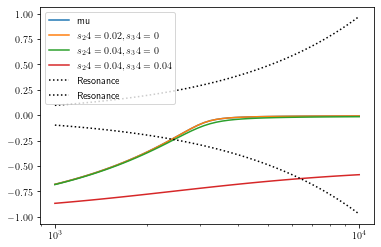

In [340]:
dm0 = np.array([func(2*En*1e18*V_nc,np.arcsin(np.sqrt(0.02))/2,0 ) for En in np.logspace(3,4,50)])
dm1 = np.array([func(2*En*1e18*V_nc,np.arcsin(np.sqrt(0.02))/2,0 ) for En in np.logspace(3,4,50)])
dm2 = np.array([func(2*En*1e18*V_nc,np.arcsin(np.sqrt(0.04))/2,0 ) for En in np.logspace(3,4,50)])
dm3 = np.array([func(2*En*1e18*V_nc,np.arcsin(np.sqrt(0.2))/2,0 ) for En in np.logspace(3,4,50)])
dm4 = np.array([func(2*En*1e18*V_nc,np.arcsin(np.sqrt(0.3)),np.arcsin(np.sqrt(0.3)) ) for En in np.logspace(3,4,50)])
plt.plot(np.logspace(3,4,50), dm0, label='mu')
plt.plot(np.logspace(3,4,50), dm1, label='$s_24 = 0.02, s_34=0$')
plt.plot(np.logspace(3,4,50), dm2, label='$s_24 = 0.04, s_34=0$')
plt.plot(np.logspace(3,4,50), dm4, label='$s_24 = 0.04, s_34=0.04$')
plt.plot(np.logspace(3,4,50), resonance(np.logspace(3,4,50))[0], c='black', label='Resonance', ls='dotted')
plt.plot(np.logspace(3,4,50), resonance(np.logspace(3,4,50))[1], c='black', label='Resonance', ls='dotted')
plt.xscale('log')
plt.legend()

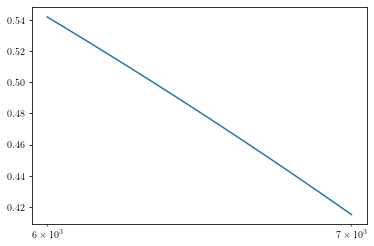

In [343]:
def resonance_c_product(E,A, params):
    '''
    E in GeV, A in eV^2
    '''
    dm = params['dm_41']
    V = 2*E*A
    dm_res = -2*E*np.pi/(GeV2tokm1*2*r_earth)
    return 1 - dm_res/dm - dm_res/A + dm_res**2/(A*dm)
prod = [resonance_c_product(En, 2*En*1e18*V_nc, param_dict_num) for En in np.logspace(np.log10(6e3),np.log10(7e3),50)]
plt.plot(np.logspace(np.log10(6e3),np.log10(7e3),50), prod)
plt.xscale('log')

In [342]:
theta_24 = np.arcsin(np.sqrt(0.3))
theta_34 = np.arcsin(np.sqrt(0.3))
print(np.cos(theta_24)**2*np.cos(theta_34)**2), print(resonance_c_product(6.5e3, 2*6.5e3*1e18*V_nc, param_dict_num))

0.4900000000000001
0.47855688132826124


(None, None)

In [66]:
dm[0],dm[-1]

(-0.9999999996789395, -0.9999999967893927)

In [112]:
H=get_H_(E,symb_params,mtype='single', anti=True, V = 1)
H

Matrix([
[1000000000.0,                                                   0,                                                      0,                                                         0],
[           0,                          5.0e-10*sin(theta_24)**2/E,    5.0e-10*sin(theta_24)*sin(theta_34)*cos(theta_24)/E,       5.0e-10*sin(theta_24)*cos(theta_24)*cos(theta_34)/E],
[           0, 5.0e-10*sin(theta_24)*sin(theta_34)*cos(theta_24)/E,            5.0e-10*sin(theta_34)**2*cos(theta_24)**2/E,    5.0e-10*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/E],
[           0, 5.0e-10*sin(theta_24)*cos(theta_24)*cos(theta_34)/E, 5.0e-10*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/E, 5.0e-10*(1.0e+18*E + cos(theta_24)**2*cos(theta_34)**2)/E]])

In [47]:
UM_list = []
#for V in [1e-13,2e-13,3e-13]:
for E in [1e3]:#,2e3,3e3]:
    H=get_H_(E,symb_params,mtype='single', anti=True, V = 1e-13)
    UM, HM = H.diagonalize(reals_only=False,sort=True, normalize=True)
    UM[:,0],UM[:,1] = UM[:,1],UM[:,0]
    UM[:,1],UM[:,2] = UM[:,2],UM[:,1]
    UM_a1 = UM[:,1]
    UM_a4 = UM[:,3]

    UM_e4 = UM_a4[0]
    UM_m4 = UM_a4[1]
    UM_t4 = UM_a4[2]
    UM_s4 = UM_a4[3]

    UM_list.append(UM_t4)

<class 'sympy.matrices.dense.MutableDenseMatrix'>


NameError: name 'UM_list' is not defined

In [48]:
UM_t4

166666666666667.0*(4.99999998333333e+22*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 5.00000001666667e+22)*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(sqrt(1.11111112592593e-17*(0.999999993333333*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 1)**2*sin(theta_34)**2*cos(theta_24)**4*cos(theta_34)**2/(3.33333333333334e-9*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5*cos(theta_24)**2*cos(theta_34)**2 + 1.0*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 1.00000000444445e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**2 + 1.11111111851852e-17*(3.33333333333334e-9*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5*cos(theta_24)**2 + 1.0*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 6.6666666888889e-9*cos(theta_24)**2*cos(theta_34)**2 + 3.33333335555556e-9*cos(theta_24)**2 + 1)**2*sin(theta_24)**2*cos(theta_24)**2*cos(theta_34)**2/(1.11111111481482e-17*(1.33333334222222e-8*cos(thet

In [49]:
c2_24, c2_34 = sp.symbols('c^2_24 c^2_34', real = True, constant=True)

In [50]:
HM[3,3].subs({sp.cos(th_24)**2: c2_24, sp.cos(th_34)**2: c2_34})

2.49999999166667e-5*(1.33333334222222e-8*c^2_24*c^2_34 + 1)**0.5 + 2.50000000833333e-5

In [191]:
ex1

166666666666667.0*(4.99999998333333e+22*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 5.00000001666667e+22)*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(sqrt(1.11111112592593e-17*(0.999999993333333*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 1)**2*sin(theta_34)**2*cos(theta_24)**4*cos(theta_34)**2/(3.33333333333334e-9*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5*cos(theta_24)**2*cos(theta_34)**2 + 1.0*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 1.00000000444445e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**2 + 1.11111111851852e-17*(3.33333333333334e-9*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5*cos(theta_24)**2 + 1.0*(1.33333334222222e-8*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 + 6.6666666888889e-9*cos(theta_24)**2*cos(theta_34)**2 + 3.33333335555556e-9*cos(theta_24)**2 + 1)**2*sin(theta_24)**2*cos(theta_24)**2*cos(theta_34)**2/(1.11111111481482e-17*(1.33333334222222e-8*cos(thet

In [214]:
ex1 = UM_list[0].subs({sp.cos(th_24)**2: c2_24, sp.cos(th_34)**2: c2_34})
UM_with_constants= ex1
const_list=[]
values_list=[]
const_dict={}
const = sp.numbered_symbols("A", cls=sp.Dummy)
for a in sp.preorder_traversal(ex1):
    if isinstance(a, sp.Float) and a != 0.5:
        c = next(const)
        const_dict[c]=a
        const_list.append(c)
        values_list.append(a)
        UM_with_constants = UM_with_constants.subs(a, c)

In [215]:
const_dict

{_A0: 166666666666667.,
 _A1: 1.00000000000000,
 _A2: 1.11111111851852e-17,
 _A3: 3.33333335555556e-9,
 _A4: 1.00000000000000,
 _A5: 1.33333334222222e-8,
 _A6: 3.33333333333334e-9,
 _A7: 1.33333334222222e-8,
 _A8: 6.66666668888890e-9,
 _A9: 1.00000000000000,
 _A10: 1.33333334222222e-8,
 _A11: 3.33333334444445e-9,
 _A12: 2.22222223703705e-17,
 _A13: 3.33333335925927e-17,
 _A14: 3.33333334444445e-9,
 _A15: 1.33333334222222e-8,
 _A16: 1.33333334000000e-8,
 _A17: 1.11111111481482e-17,
 _A18: 1.33333334222222e-8,
 _A19: 6.66666668888890e-9,
 _A20: 1.33333334222222e-8,
 _A21: 1.11111112592593e-17,
 _A22: 0.999999993333333,
 _A23: 1.33333334222222e-8,
 _A24: 1.00000000000000,
 _A25: 1.33333334222222e-8,
 _A26: 1.00000000444445e-8,
 _A27: 3.33333333333334e-9,
 _A28: 1.33333334222222e-8,
 _A29: 2.49999999166667e+45,
 _A30: 2.49999999166667e+45,
 _A31: 1.33333334222222e-8,
 _A32: 2.50000000277778e+37,
 _A33: 8.33333330555557e+36,
 _A34: 1.33333334222222e-8,
 _A35: 5.00000001666667e+22,
 _A36: 4.

In [216]:
replacements =[]
formulas = []
for UM_t4 in [UM_with_constants]:
    replacement, UM_t4_formula = sp.cse(UM_t4, ignore=[c2_24, c2_34])
    UM_t4_formula = UM_t4_formula[0]
    x = np.array(replacement)[:,1]
    replacements.append(replacement)
    formulas.append(UM_t4_formula)


In [217]:
replacements[0]

[(x0, sin(theta_34))]

In [218]:
UM_with_constants
dm = sp.symbols('dm')
#dm = (const_list[5]*c2_24*c2_34+1)**0.5
# det är mittentermen (prop till s34^2 c24^4 c34^2) som exploderar. Den första termen är konstant (1e-16)**2

_A0*c^2_24*(_A35 + _A36*(_A5*c^2_24*c^2_34 + 1)**0.5)*(_A29 + _A30*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A32*c^2_24*c^2_34 + _A33*c^2_24*c^2_34*(_A5*c^2_24*c^2_34 + 1)**0.5)**(-_A1)*sin(theta_34)*cos(theta_34)/sqrt(_A1 + _A2*c^2_24*c^2_34*(_A3*c^2_24 + _A4*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A6*c^2_24*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A8*c^2_24*c^2_34 + 1)**2*sin(theta_24)**2/(_A11*c^2_24*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A11*c^2_24 + _A12*c^2_24**2*c^2_34**2 + _A13*c^2_24**2*c^2_34 + _A16*c^2_24*c^2_34 + _A17*c^2_24**2*c^2_34*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A8*c^2_24*c^2_34*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A9 + (_A5*c^2_24*c^2_34 + 1)**0.5)**2 + _A21*c^2_24**2*c^2_34*(_A22*(_A5*c^2_24*c^2_34 + 1)**0.5 + 1)**2*sin(theta_34)**2/(_A26*c^2_24*c^2_34 + _A4*(_A5*c^2_24*c^2_34 + 1)**0.5 + _A6*c^2_24*c^2_34*(_A5*c^2_24*c^2_34 + 1)**0.5 + 1)**2)

In [258]:
UM_with_dm = UM_with_constants.subs((const_list[5]*c2_24*c2_34+1)**0.5, dm)

In [260]:
UM_with_dm

_A0*c^2_24*(_A35 + _A36*dm)*(_A29 + _A30*dm + _A32*c^2_24*c^2_34 + _A33*c^2_24*c^2_34*dm)**(-_A1)*sin(theta_34)*cos(theta_34)/sqrt(_A1 + _A2*c^2_24*c^2_34*(_A3*c^2_24 + _A4*dm + _A6*c^2_24*dm + _A8*c^2_24*c^2_34 + 1)**2*sin(theta_24)**2/(_A11*c^2_24*dm + _A11*c^2_24 + _A12*c^2_24**2*c^2_34**2 + _A13*c^2_24**2*c^2_34 + _A16*c^2_24*c^2_34 + _A17*c^2_24**2*c^2_34*dm + _A8*c^2_24*c^2_34*dm + _A9 + dm)**2 + _A21*c^2_24**2*c^2_34*(_A22*dm + 1)**2*sin(theta_34)**2/(_A26*c^2_24*c^2_34 + _A4*dm + _A6*c^2_24*c^2_34*dm + 1)**2)

In [112]:
def dm_func(E,V,theta24,theta34,a):
    return np.sqrt(np.cos(theta24)**2*np.cos(theta34)**2/(a*E*V) + 1)
    #return sp.sqrt(const_list[4]*np.cos(theta24)**2*np.cos(theta34)**2+1)
def func(E,V,theta24,theta34,a):
    dm = dm_func(E,V,theta24,theta34,a)
    s34 = np.sin(theta34)
    s24 = np.sin(theta24)
    return const_list[20]*x[0]**2*x[10]*(const_list[21]*dm+1)**2/(const_list[25]*x[5]+x[5]*const_list[5]*dm+const_list[3]*dm+1)**2
def func_eval(E,V,theta24,theta34,C):
    f = func(E,V,theta24,theta34,a=C)
    f_clear = f.subs(const_dict).subs(replacements[0]).subs(replacements[0]).subs({th_24: theta24, th_34:theta34})
    return f_clear

In [118]:
func_eval(3e3,V,theta24=0.04,theta34=0.02,C=1e22)
#dm_func(E,V,theta24=0.04,theta34=0.02,a=1e-10)


4.42787885074950e-21

In [172]:
(x[0]**2*x[10]*dm_func(E,V,theta24=0.01,theta34=0.02,a=1)).subs(replacements[0]).subs(replacements[0]).subs(const_dict)

1.00000000666333*sin(theta_34)**2*cos(theta_24)**4*cos(theta_34)**2

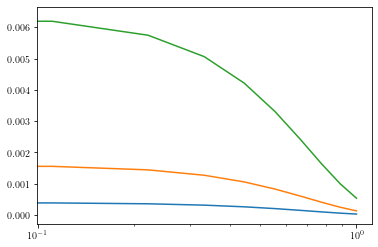

In [181]:
E=3e3
V = 1e-13
theta24 = 0.04
theta34 = 0.02
fig,ax = plt.subplots(1)
U = np.array([(x[0]**2*x[10]*dm_func(E,V,theta24=0.02,theta34=th,a=1e10)).subs(replacements[0]).subs(replacements[0]).subs(const_dict).subs({th_24: th, th_34:0.02}) for th in np.linspace(0,1,10)], dtype=np.float64)
U1 = np.array([(x[0]**2*x[10]*dm_func(E,V,theta24=0.04,theta34=th,a=1e10)).subs(replacements[0]).subs(replacements[0]).subs(const_dict).subs({th_24: th, th_34:0.04}) for th in np.linspace(0,1,10)], dtype=np.float64)
U2 = np.array([(x[0]**2*x[10]*dm_func(E,V,theta24=0.08,theta34=th,a=1e10)).subs(replacements[0]).subs(replacements[0]).subs(const_dict).subs({th_24: th, th_34:0.08}) for th in np.linspace(0,1,10)], dtype=np.float64)
#U1 = [func(En,V,0.04,0.02,1,1,1,1,1) for En in np.linspace(1e3,1e4,100)]
ax.plot(np.linspace(0,1,10),U)
ax.plot(np.linspace(0,1,10),U1)
ax.plot(np.linspace(0,1,10),U2)
#plt.plot(np.linspace(1e3,1e4,100),U1)
ax.set_xscale('log')

<ipython-input-178-e279f9546b76>:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.linspace(0,1,10),1/np.sqrt(U**2),label='0.02')
<ipython-input-178-e279f9546b76>:6: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.linspace(0,1,10),1/np.sqrt(U1**2),label='0.04')
<ipython-input-178-e279f9546b76>:7: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.linspace(0,1,10),1/np.sqrt(U2**2),label='0.08')


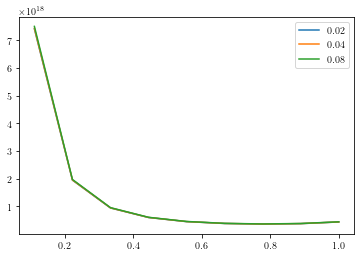

In [178]:
fig,ax = plt.subplots(1)
U = np.array([func_eval(E,V,theta24=0.02,theta34=th,C=1) for th in np.linspace(0,1,10)], dtype=np.float64)
U1 = np.array([func_eval(E,V,theta24=0.04,theta34=th,C=1) for th in np.linspace(0,1,10)], dtype=np.float64)
U2 = np.array([func_eval(E,V,theta24=0.08,theta34=th,C=1) for th in np.linspace(0,1,10)], dtype=np.float64)
ax.plot(np.linspace(0,1,10),1/np.sqrt(U**2),label='0.02')
ax.plot(np.linspace(0,1,10),1/np.sqrt(U1**2),label='0.04')
ax.plot(np.linspace(0,1,10),1/np.sqrt(U2**2),label='0.08')
ax.legend()
#ax.set_xscale('log')

In [176]:
from plotter import P_over_E_parameter
from events import list_of_params
params = list_of_params(ic_params, [1], [0.02,0.04,0.08],np.linspace(0,1,10))
P = P_over_E_parameter('m',params,E_range=[3e3],ndim=4,anti=True)
Pmm = P[:,1].reshape(3,10)

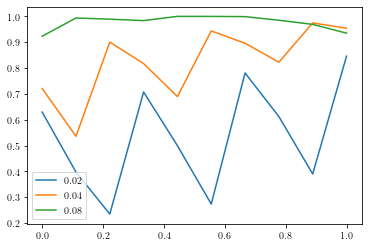

In [177]:
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0,1,10),Pmm[0],label='0.02')
ax.plot(np.linspace(0,1,10),Pmm[1],label='0.04')
ax.plot(np.linspace(0,1,10),Pmm[2],label='0.08')
ax.legend()

In [170]:
e22,e23,e24,e32,e33,e34,e42,e43,e44 = sp.symbols('e_22,e_23,e_24,e_32,e_33,e_34,e_42,e_43,e_44')
e22_prim,e23_prim,e24_prim,e32_prim,e33_prim,e34_prim,e42_prim,e43_prim,e44_prim = sp.symbols('e´_22,e´_23,e´_24,e´_32,e´_33,e´_34,e´_42,e´_43,e´_44')
def R34_3(theta):
  return sp.Matrix([[ 1,             0,             0],
                   [ 0, sp.cos(theta),  sp.sin(theta)],
                   [ 0, -sp.sin(theta), sp.cos(theta)]])
def R24_3(theta):
  return sp.Matrix([[ sp.cos(theta), 0, sp.sin(theta)],
                   [ 0,             1,             0],
                   [-sp.sin(theta), 0, sp.cos(theta)]])
R_34 = R34_3(th_34)
R_24 =  R24_3(th_24)
U_red = R_34 @ R_24
E = sp.Matrix([[e22,e23,e24],[e32,e33,e34],[e42,e43,e44]])
E_prim_symb = sp.Matrix([[e22_prim,e23_prim,e24_prim],[e32_prim,e33_prim,e34_prim],[e42_prim,e43_prim,e44_prim]])
E_prim = R_34.T @ E @ R_34
mass = sp.diag(0,0,param_dict_sym['dm_41'])

In [174]:
#U_red @ mass @ U_red.T + E
M= R_34 @( R_24 @ mass @ R_24.T + E_prim_symb) @ R_34.T

In [189]:
delta_34_prim = E_prim_symb[5]/m_41
#LO corection to m_4 is e_33_prim = E_prim[4]
R_24 @ mass @ R_24.T + E_prim_symb
V = R_34  @ R34_3(delta_34_prim)@R_24

In [190]:
V

Matrix([
[                                                                    cos(theta_24),                                                                0,                                                                    sin(theta_24)],
[ -(sin(theta_34)*cos(e´_34/dm_41) + sin(e´_34/dm_41)*cos(theta_34))*sin(theta_24), -sin(theta_34)*sin(e´_34/dm_41) + cos(theta_34)*cos(e´_34/dm_41),  (sin(theta_34)*cos(e´_34/dm_41) + sin(e´_34/dm_41)*cos(theta_34))*cos(theta_24)],
[-(-sin(theta_34)*sin(e´_34/dm_41) + cos(theta_34)*cos(e´_34/dm_41))*sin(theta_24), -sin(theta_34)*cos(e´_34/dm_41) - sin(e´_34/dm_41)*cos(theta_34), (-sin(theta_34)*sin(e´_34/dm_41) + cos(theta_34)*cos(e´_34/dm_41))*cos(theta_24)]])

In [191]:
sp.simplify(V)

Matrix([
[                             cos(theta_24),                            0,                             sin(theta_24)],
[-sin(theta_24)*sin(theta_34 + e´_34/dm_41),  cos(theta_34 + e´_34/dm_41), sin(theta_34 + e´_34/dm_41)*cos(theta_24)],
[-sin(theta_24)*cos(theta_34 + e´_34/dm_41), -sin(theta_34 + e´_34/dm_41), cos(theta_24)*cos(theta_34 + e´_34/dm_41)]])

In [3]:
A_cc, A_nc=sp.symbols('A_cc,A_nc')
U = V_matrix(3,4,1, params=symb_params_simple) @ V_matrix(2,4,1, params=symb_params_simple)@ V_matrix(1,4,1, params=symb_params_simple)

M = sp.diag(0,0,0,param_dict_sym['dm_41'])
H = 1/(2*E)*(U @ M @ sp.transpose(U) + sp.diag(A_cc,0,0,A_nc))
H_sterile = sp.Matrix([H[5:8],H[9:12],H[13:16]])

In [10]:
H_sterile

Matrix([
[                         dm_41*sin(theta_24)**2/(2*E),    dm_41*sin(theta_24)*sin(theta_34)*cos(theta_24)/(2*E),    dm_41*sin(theta_24)*cos(theta_24)*cos(theta_34)/(2*E)],
[dm_41*sin(theta_24)*sin(theta_34)*cos(theta_24)/(2*E),            dm_41*sin(theta_34)**2*cos(theta_24)**2/(2*E), dm_41*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(2*E)],
[dm_41*sin(theta_24)*cos(theta_24)*cos(theta_34)/(2*E), dm_41*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(2*E),   (A_nc + dm_41*cos(theta_24)**2*cos(theta_34)**2)/(2*E)]])

In [11]:
sp.Matrix([H_sterile[3:5],H_sterile[6:8]])

Matrix([
[dm_41*sin(theta_24)*sin(theta_34)*cos(theta_24)/(2*E),            dm_41*sin(theta_34)**2*cos(theta_24)**2/(2*E)],
[dm_41*sin(theta_24)*cos(theta_24)*cos(theta_34)/(2*E), dm_41*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(2*E)]])

In [12]:
#Denton for Um
lamda = 2*E*np.array(list(H_sterile.eigenvals().keys()))
H_mu = sp.Matrix([H_sterile[4:6],H_sterile[7:9]])
H_tau = sp.Matrix([[H_sterile[0],H_sterile[2]],[H_sterile[6],H_sterile[8]]])
H_s = sp.Matrix([H_sterile[0:2],H_sterile[3:5]])
#H_sub = sp.Matrix([H[5:8],H[9:12],H[13:16]])
#H_sub = sp.Matrix([H[0:3],H[3:6],H[12:15]])
#H_sub = sp.Matrix([H_sterile[0:2],H_sterile[6:8]])
#H_sub = sp.Matrix([H_sterile[0:2],H_sterile[3:5]])
chi, eta = 2*E*np.array(list(H_s.eigenvals().keys()))

In [13]:
U_m2 = (lamda[0]-eta)*(lamda[0]-chi)/((lamda[0]-lamda[1])*(lamda[0]-lamda[2]))
U_m4 = (lamda[1]-eta)*(lamda[1]-chi)/((lamda[1]-lamda[2])*(lamda[1]-lamda[0]))
U_m3 = (lamda[2]-eta)*(lamda[2]-chi)/((lamda[2]-lamda[1])*(lamda[2]-lamda[0]))
U_m2_func = sp.lambdify([E,th_24,th_34],U_m2.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
U_m3_func = sp.lambdify([E,th_24,th_34],U_m3.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
U_m4_func = sp.lambdify([E,th_24,th_34],U_m4.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')

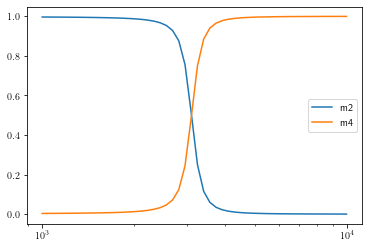

In [14]:
E_range = np.logspace(3,4,50)
#plt.plot(E_range, U_m1_func(E_range,0.04,0), label='m2')
plt.plot(E_range, U_m2_func(E_range,0.04,0), label='m2')
#plt.plot(E_range, U_m3_func(E_range,0.04,0), label='m3')
plt.plot(E_range, U_m4_func(E_range,0.04,0), label='m4')
plt.xscale('log')
plt.legend()

In [83]:
sp.simplify(U_m2.subs({A_nc:0,A_cc:0, m_41:-1}))

cos(theta_24)**2*cos(theta_34)**2

In [80]:
sp.simplify(U_m3.subs({A_nc:0,A_cc:0, m_41:-1}))

0

In [84]:
sp.simplify(U_m4.subs({A_nc:0,A_cc:0, m_41:-1}))

-cos(theta_24)**2*cos(theta_34)**2 + 1

In [27]:
sp.matrix_multiply_elementwise(U,U)

Matrix([
[1,                                 0,                0,                                 0],
[0,                  cos(theta_24)**2,                0,                  sin(theta_24)**2],
[0, sin(theta_24)**2*sin(theta_34)**2, cos(theta_34)**2, sin(theta_34)**2*cos(theta_24)**2],
[0, sin(theta_24)**2*cos(theta_34)**2, sin(theta_34)**2, cos(theta_24)**2*cos(theta_34)**2]])

In [86]:
sp.simplify(U_m2)

(-A_nc - 2*dm_41*cos(theta_24)**2*cos(theta_34)**2 + dm_41 + sqrt(A_nc**2 + 4*A_nc*dm_41*cos(theta_24)**2*cos(theta_34)**2 - 2*A_nc*dm_41 + dm_41**2))/(2*sqrt(A_nc**2 + 4*A_nc*dm_41*cos(theta_24)**2*cos(theta_34)**2 - 2*A_nc*dm_41 + dm_41**2))

In [87]:
H

Matrix([
[A_cc/(2*E),                                                     0,                                                        0,                                                        0],
[         0,                          dm_41*sin(theta_24)**2/(2*E),    dm_41*sin(theta_24)*sin(theta_34)*cos(theta_24)/(2*E),    dm_41*sin(theta_24)*cos(theta_24)*cos(theta_34)/(2*E)],
[         0, dm_41*sin(theta_24)*sin(theta_34)*cos(theta_24)/(2*E),            dm_41*sin(theta_34)**2*cos(theta_24)**2/(2*E), dm_41*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(2*E)],
[         0, dm_41*sin(theta_24)*cos(theta_24)*cos(theta_34)/(2*E), dm_41*sin(theta_34)*cos(theta_24)**2*cos(theta_34)/(2*E),   (A_nc + dm_41*cos(theta_24)**2*cos(theta_34)**2)/(2*E)]])

In [349]:
#Denton for Um
lamda = 2*E*np.array(list(H.eigenvals().keys()))
H_e = sp.Matrix([H[5:8],H[9:12],H[13:16]])
H_mu = sp.Matrix([[H[0],H[2],H[3]], [H[8],H[10],H[11]], [H[12],H[14],H[15]] ])
H_tau = sp.Matrix([[H[0],H[1],H[3]], [H[4],H[5],H[7]], [H[12],H[13],H[15]] ])
H_s = sp.Matrix([H[0:3],H[4:7],H[8:11]])
chim, etam,xim = 2*E*np.array(list(H_mu.eigenvals().keys()))
chit, etat,xit = 2*E*np.array(list(H_tau.eigenvals().keys()))
chis, etas,xis = 2*E*np.array(list(H_s.eigenvals().keys()))

In [350]:

'''
#U_m2 = (lamda[3]-eta)*(lamda[3]-chi)*(lamda[3]-xi)/((lamda[3]-lamda[1])*(lamda[3]-lamda[2])*(lamda[3]-lamda[0]))
#U_m1 = (lamda[0]-eta)*(lamda[0]-chi)*(lamda[0]-xi)/((lamda[0]-lamda[1])*(lamda[0]-lamda[2])*(lamda[0]-lamda[3]))
#U_m4 = (lamda[1]-eta)*(lamda[1]-chi)*(lamda[1]-xi)/((lamda[1]-lamda[2])*(lamda[1]-lamda[0])*(lamda[1]-lamda[3]))
#U_m3 = (lamda[2]-eta)*(lamda[2]-chi)*(lamda[2]-xi)/((lamda[2]-lamda[1])*(lamda[2]-lamda[0])*(lamda[2]-lamda[3]))
U_m1_func = sp.lambdify([E,th_24,th_34],U_m1.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
U_m2_func = sp.lambdify([E,th_24,th_34],U_m2.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
U_m3_func = sp.lambdify([E,th_24,th_34],U_m3.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
U_m4_func = sp.lambdify([E,th_24,th_34],U_m4.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
'''
Um2 = (lamda[2]-etam)*(lamda[2]-chim)*(lamda[2]-xim)/((lamda[2]-lamda[1])*(lamda[2]-lamda[0])*(lamda[2]-lamda[3]))
Um1 = (lamda[0]-etam)*(lamda[0]-chim)*(lamda[0]-xim)/((lamda[0]-lamda[1])*(lamda[0]-lamda[2])*(lamda[0]-lamda[3]))
Um4 = (lamda[1]-etam)*(lamda[1]-chim)*(lamda[1]-xim)/((lamda[1]-lamda[2])*(lamda[1]-lamda[0])*(lamda[1]-lamda[3]))
Um3 = (lamda[3]-etam)*(lamda[3]-chim)*(lamda[3]-xim)/((lamda[3]-lamda[1])*(lamda[3]-lamda[2])*(lamda[3]-lamda[0]))

Ut2 = (lamda[2]-etat)*(lamda[2]-chit)*(lamda[2]-xit)/((lamda[2]-lamda[1])*(lamda[2]-lamda[0])*(lamda[2]-lamda[3]))
Ut1 = (lamda[0]-etat)*(lamda[0]-chit)*(lamda[0]-xit)/((lamda[0]-lamda[2])*(lamda[0]-lamda[2])*(lamda[0]-lamda[3]))
Ut4 = (lamda[1]-etat)*(lamda[1]-chit)*(lamda[1]-xit)/((lamda[1]-lamda[2])*(lamda[1]-lamda[0])*(lamda[1]-lamda[3]))
Ut3 = (lamda[3]-etat)*(lamda[3]-chit)*(lamda[3]-xit)/((lamda[3]-lamda[1])*(lamda[3]-lamda[2])*(lamda[3]-lamda[0]))

Us2 = (lamda[2]-etas)*(lamda[2]-chis)*(lamda[2]-xis)/((lamda[2]-lamda[1])*(lamda[2]-lamda[0])*(lamda[2]-lamda[3]))
Us1 = (lamda[0]-etas)*(lamda[0]-chis)*(lamda[0]-xis)/((lamda[0]-lamda[2])*(lamda[0]-lamda[2])*(lamda[0]-lamda[3]))
Us4 = (lamda[1]-etas)*(lamda[1]-chis)*(lamda[1]-xis)/((lamda[1]-lamda[2])*(lamda[1]-lamda[0])*(lamda[1]-lamda[3]))
Us3 = (lamda[3]-etas)*(lamda[3]-chis)*(lamda[3]-xis)/((lamda[3]-lamda[1])*(lamda[3]-lamda[2])*(lamda[3]-lamda[0]))

Um2_func = sp.lambdify([E,th_24,th_34],Um2.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
Um4_func = sp.lambdify([E,th_24,th_34],Um4.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')
Ut4_func = sp.lambdify([E,th_24,th_34],Ut4.subs({'A_cc':2*E*1e18*V_cc,'A_nc': 2*E*1e18*V_nc, m_41:param_dict_num['dm_41']}),'numpy')




In [375]:
sp.matrix_multiply_elementwise(U,U).subs({th_24:np.pi/10, th_34:0})

Matrix([
[1,                  0, 0,                  0],
[0,  0.904508497187474, 0, 0.0954915028125263],
[0,                  0, 1,                  0],
[0, 0.0954915028125263, 0,  0.904508497187474]])

In [396]:
UM = sp.Matrix([[Um1,Um2,Um3,Um4],[Ut1,Ut2,Ut3,Ut4],[Us1,Us2,Us3,Us4]])
UM.subs({'A_nc':1e-10,'A_cc':0, m_41:-1, E:3e3,th_24:np.pi/10, th_34:0})

Matrix([
[0,  0.904506073522245,   0,   0.0954915028298009],
[0,                  0, 1.0, 1.11022302472558e-16],
[0, 0.0954915028298009,   0,    0.904508497170199]])

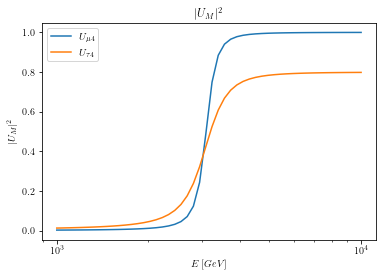

In [224]:
E_range = np.logspace(3,4,50)
plt.plot(E_range, Um4_func(E_range,0.04,0), label='$U_{\mu 4}$')
#plt.plot(E_range, U_m2_func(E_range,0.04,0), label='m2')
plt.plot(E_range, Ut4_func(E_range,0.04,0.08), label='$U_{\\tau 4}$')
plt.ylabel('$|U_M|^2$')
plt.xscale('log')
plt.title('$|U_M|^2$')
plt.xlabel('$E\, [GeV]$')
plt.legend()

In [229]:
sp.matrix_multiply_elementwise(U,U).subs({th_24:np.pi/3, th_34:0})

Matrix([
[1,                                 0,                0,                                 0],
[0,                  cos(theta_24)**2,                0,                  sin(theta_24)**2],
[0, sin(theta_24)**2*sin(theta_34)**2, cos(theta_34)**2, sin(theta_34)**2*cos(theta_24)**2],
[0, sin(theta_24)**2*cos(theta_34)**2, sin(theta_34)**2, cos(theta_24)**2*cos(theta_34)**2]])

In [230]:
lamda[1].subs({'A_nc':2*E*1e18*V_nc, m_41:-1,th_24:0.1,th_34:0,E:3e3})

-0.116438757793665

In [551]:
t24 = sp.asin(sp.sqrt(Um4))
t34 = sp.asin(sp.sqrt(Ut4/sp.cos(t24)**2))

In [579]:
Ut3_test = sp.cos(t34)**2
Ut2_test = sp.sin(t24)**2*sp.sin(t34)**2

In [580]:
sp.simplify((Ut3_test+Ut2_test + Ut4).subs({'A_nc':1, m_41:-1,th_24:0.1,th_34:0,E:3e3}))

1.00000000000000

In [629]:
dmM_41 = lamda[1]
dmM_21 = lamda[2]
dmM_31 = lamda[0]

dmM_21_func = sp.lambdify([E,th_24,th_34,m_41],dmM_21.subs({'A_nc':2*E*1e18*V_nc, 'A_cc':2*E*1e18*V_cc}))
dmM_31_func = sp.lambdify([E,th_24,th_34,m_41],dmM_31.subs({'A_nc':2*E*1e18*V_nc, 'A_cc':2*E*1e18*V_cc}))
dmM_41_func = sp.lambdify([E,th_24,th_34,m_41],dmM_41.subs({'A_nc':2*E*1e18*V_nc, 'A_cc':2*E*1e18*V_cc}))

dmM_42 = dmM_41 - dmM_21
dmM_32 = dmM_31 - dmM_21
dmM_43 = dmM_41 - dmM_31
Pmm = 1-4*((1-Um4)*Um4*sp.sin(dmM_42*2*r_earth/(4*E)*GeV2tokm1)**2)# + Um3*Um4*sp.sin(dmM_43*2*r_earth/(4*E)*GeV2tokm1)**2)# + Um3*Um2*sp.sin(dmM_32*2*r_earth/(4*E)*GeV2tokm1)**2)
Pmt = 4*((1-Um4)*Ut2*Um4*Ut4*sp.sin(dmM_42*2*r_earth/(4*E)*GeV2tokm1)**2)

Pmm_func = sp.lambdify([E,th_24,th_34, m_41],Pmm.subs({'A_nc':2*E*1e18*V_nc, 'A_cc':2*E*1e18*V_cc}))
Pmt_func = sp.lambdify([E,th_24,th_34, m_41],Pmt.subs({'A_nc':2*E*1e18*V_nc, 'A_cc':2*E*1e18*V_cc}))

In [630]:
param_dict_num.update({'theta_24':0.1,'theta_34':0.1,'dm_41':-1})
Panti_num = P_num('m',E_range,ndim=4, params=param_dict_num, vacuum=False, anti=False, material=8.44) #dm here is negative, so anti=False gives anti P
Pnum = P_num('m',E_range,ndim=4, params=param_dict_num, vacuum=False, anti=True, material=8.44)
P_numerical = [Pnum[1], Pnum[2], Panti_num[1], Panti_num[2]]

Text(0.5, 0.98, 'Oscillation probabilities')

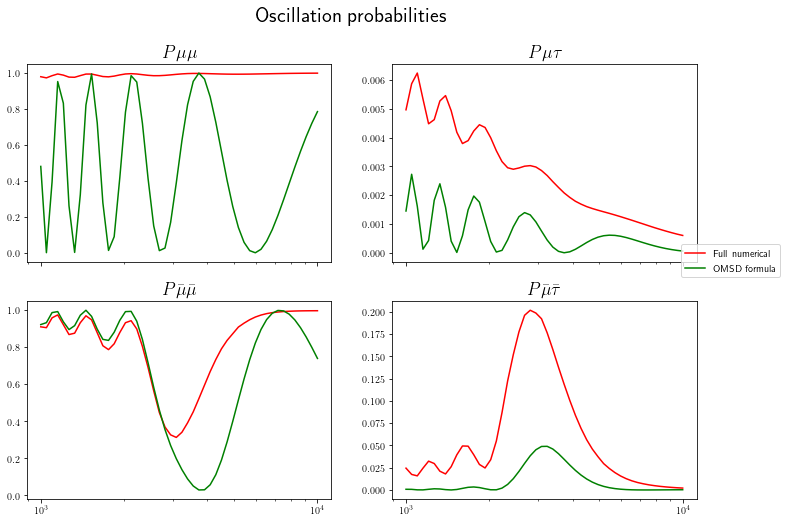

In [631]:
flavors=['\\mu\\mu','\\mu\\tau','\\bar{\\mu}\\bar{\\mu}','\\bar{\\mu}\\bar{\\tau}']

fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches((12,8))
ax = ax.flatten()



Pamam_omsd = Pmm_func(E_range,param_dict_num['theta_24'], param_dict_num['theta_34'],param_dict_num['dm_41'])
Pmm_omsd = Pmm_func(E_range,param_dict_num['theta_24'], param_dict_num['theta_34'],-param_dict_num['dm_41'])

Pamat_omsd = Pmt_func(E_range,param_dict_num['theta_24'], param_dict_num['theta_34'],param_dict_num['dm_41'])
Pmt_omsd = Pmt_func(E_range,param_dict_num['theta_24'], param_dict_num['theta_34'],-param_dict_num['dm_41'])
P_omsd = [Pmm_omsd, Pmt_omsd, Pamam_omsd, Pamat_omsd]
for i in range(4):
    ax[i].set_title(rf'$P{flavors[i]}$',fontsize=18)
    #ax[i].set_ylim((-0.01,1.01))
    ax[i].set_xscale('log')

    ax[i].plot(E_range, P_numerical[i], label='Full numerical', c='r')
    ax[i].plot(E_range, P_omsd[i], label='OMSD formula', c='g')
    #ax[i].plot(E_range, P_an_list_single, label='OMSD an',linestyle='--', c='black')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.suptitle('Oscillation probabilities', fontsize=21)